In [21]:
import geometry
import numpy as np
import numba as nb
import ezdxf

In [23]:
# Load geometry
doc = ezdxf.readfile("oblong_rectangle.dxf")
msp = doc.modelspace()

In [37]:
# Get all polylines
polylines = msp.query("LWPOLYLINE")
paths = [np.array(x.get_points())[:, [0, 1, 4]] for x in polylines]

In [15]:
line1 = geometry.LineSegment(geometry.Vec2D(0.5, -1), geometry.Vec2D(0.5, 0.499999))
line2 = geometry.LineSegment(geometry.Vec2D(0, 1), geometry.Vec2D(1, 0))
arc = geometry.ArcSegment(geometry.Vec2D(100, 0), 99, np.pi/2, 3*np.pi/2, True)

# arc.radius

# line2.intersection(line1)
line1.intersection(arc)

line1.intersects(line2)
# line1.intersection(line2)

# np.linalg.solve(np.array([[-1, 0], []]))

False

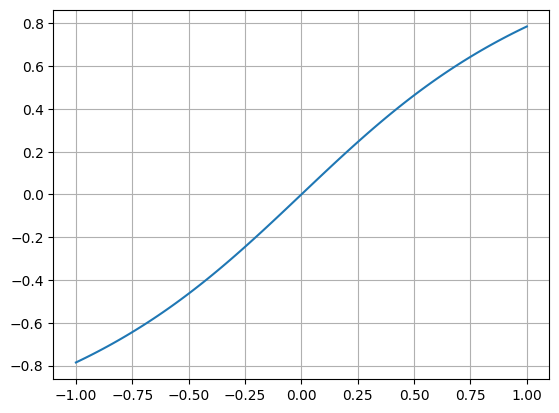

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 100)
y = np.atan(x)

plt.plot(x, y)
plt.grid()